# Forest Analysis

In [27]:
# Import necessary stuff
import pandas as pd
import numpy as np
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [21]:
# convert to numeric, drop nas and other [currently] irrelevant features
def preprocess(filename):
    df = pd.read_csv(filename+'.csv', sep=",")

    # removing unnecessary columns. keeping only numbers atm
    unnecessary = ['Body','ClosedDate','CommunityOwnedDate','CreationDate','Id','LastActivityDate',
              'LastEditDate','LastEditorUserId','LastEditorDisplayName','OwnerDisplayName',
              'OwnerUserId','ParentId','Tags','Title','Clean_Text','AcceptedAnswerId','Score',
              'AnswerCount', 'CommentCount', 'FavoriteCount', 'PostTypeId','ViewCount']

    droppable = np.intersect1d(df.columns,unnecessary)
    df = df.drop(droppable, 1)
    df = df.dropna()
    if df.shape[0]>30000:
        df = df[:30000]
    # df = df.apply(pd.to_numeric)
    return df

In [12]:
# Getting the best random forest parameters
def gridSearching(rfc, X, Y):
    '''
    All Parameters in a RFC
                'max_depth':[None],
                'min_samples_split':[2],
                'min_samples_leaf':[1],
                'min_weight_fraction_leaf':[0.0],
                'max_leaf_nodes':[None],
                'min_impurity_split':[1e-07],
                'bootstrap':[True],
                'oob_score':[False],
                'n_jobs':[1],
                'random_state':[None],
                'verbose':[0],
                'warm_start':[False],
                'class_weight':[None],
                'max_features: [sqrt],
                'criterion': ['gini'],
                'n_estimators' : [10]
    '''

    param_grid = {'n_estimators': np.arange(10, 100, 10),
              'max_features': ['sqrt', 'log2', None],
              'criterion': ['gini', 'entropy'],
              }

    # Performing a Grid Search to find best RFC
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10)
    CV_rfc.fit(X, Y)
    print("Best parameters were {} with an accuracy of: {} over the leftout tr set".format(CV_rfc.best_params_,CV_rfc.best_score_))
    return CV_rfc.best_estimator_

In [11]:
# Show boosted RFC results
def adaboostedRFC(best_rfc,X,Y):
    from sklearn.ensemble import AdaBoostClassifier

    brfc = AdaBoostClassifier(best_rfc,
                          algorithm="SAMME.R",
                          n_estimators=10)
    bScores = cross_val_score(brfc, X, Y, cv =10)
    print('mean crossvalidated accuracy for training set after Adaboost: {}'.format(np.mean(bScores)))
    return brfc.fit(X,Y)

In [10]:
def XGBoosting(X,y,filename):
    import pandas as pd
    from xgboost import XGBClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import cross_val_score
    import numpy as np
    
    model = XGBClassifier()
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    
    # ROW SAMPLING
    subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
    param_grid = dict(subsample=subsample)
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold)
    grid_result_rs = grid_search.fit(X, y)
    print("accuracy for best row sampling on leftout set:", grid_result_rs.best_estimator_.score(X, y))

    # COLUMN SAMPLING
    colsample_bytree = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
    param_grid = dict(colsample_bytree=colsample_bytree)
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold)
    grid_result_cs = grid_search.fit(X, y)
    print("accuracy for best col sampling on leftout set:", grid_result_cs.best_estimator_.score(X, y))

    # SPLIT SAMPLE
    colsample_bylevel = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
    param_grid = dict(colsample_bylevel=colsample_bylevel)
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold)
    grid_result_ss = grid_search.fit(X, y)
    print("accuracy for best split sampling on leftout set:", grid_result_ss.best_estimator_.score(X, y))
    
    return {'rs':grid_result_rs, 'cs':grid_result_cs, 'ss':grid_result_ss}

In [17]:
def reportCard(y_true, y_pred, y_proba,name):
    from sklearn import metrics
    import matplotlib.pyplot as plt
    %matplotlib inline
    print('\nReport for:',name)
    target_names = ['low', 'high']
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    print("Confusion Matrix\n",metrics.confusion_matrix(y_true,y_pred))
    print("F1 Score:",metrics.f1_score(y_true,y_pred))
    print("Accuracy:",metrics.accuracy_score(y_true,y_pred))
    print("Log Loss:",metrics.log_loss(y_true,y_pred))
    print("AUC Score:",metrics.roc_auc_score(y_true,y_proba[:,1]))
    
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_proba[:,1])
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for {}'.format(name))
    plt.legend(loc='best')
    plt.show()

    print()
    

In [19]:
def RunForrestRun(filename):
    print("\nRunning for",filename)
    df = preprocess(filename)
    print("dataset size is:",df.shape)
    print("columns:",df.columns)

    X_tr = df.drop('ScoreLabel', 1).iloc[:int(len(df)*0.8)]
    Y_tr = df['ScoreLabel'].iloc[:int(len(df)*0.8)]
    
    X_te = df.drop('ScoreLabel', 1).iloc[int(len(df)*0.8)+1:]
    Y_te = df['ScoreLabel'].iloc[int(len(df)*0.8)+1:]
    
    print("\nRandom Forest")
    best_rfc =  gridSearching(RandomForestClassifier(),X_tr,Y_tr)
    grid_rfc_pred = best_rfc.predict(X_te)
    grid_rfc_pred_prob = best_rfc.predict_proba(X_te)

    print("\nAdaboosted")
    adaboosted = adaboostedRFC(best_rfc,X_tr,Y_tr)
    ada_pred = adaboosted.predict(X_te)
    ada_pred_prob = adaboosted.predict_proba(X_te)
       
    print("\nXG Boosted")
    xgBoosted = XGBoosting(X_tr,Y_tr,filename)
    xg_pred_rs = xgBoosted['rs'].predict(X_te)
    xg_pred_prob_rs = xgBoosted['rs'].predict_proba(X_te)
    
    xg_pred_cs = xgBoosted['cs'].predict(X_te)
    xg_pred_prob_cs = xgBoosted['cs'].predict_proba(X_te)

    xg_pred_ss = xgBoosted['ss'].predict(X_te)
    xg_pred_prob_ss = xgBoosted['ss'].predict_proba(X_te)
    
    print("*****BOF: {}*****".format(filename))
    reportCard(Y_te, grid_rfc_pred, grid_rfc_pred_prob,'GridSearched RFC')
    reportCard(Y_te, ada_pred, ada_pred_prob,'Adaboosted')
    reportCard(Y_te, xg_pred_rs, xg_pred_prob_rs,'XG RS')
    reportCard(Y_te, xg_pred_cs, xg_pred_prob_cs,'XG CS')
    reportCard(Y_te, xg_pred_ss, xg_pred_prob_ss,'XG SS')
    print("*****EOF: {}*****".format(filename))

In [24]:
#Score = Median
iot = 'iot_posts_with_readibility_measures'
ai = 'ai_posts_with_readibility_measures'
stats = 'stats_posts_with_readibility_measures'


Running for stats_posts_with_readibility_measures
dataset size is: (30000, 10)
columns: Index(['Flesch_Reading_Ease_Value', 'Coleman_Liau_Index_Value',
       'Dale_Chall_Readability_Score', 'Code_Count', 'Latex_Count',
       'Text_Length', 'Punc_Rate', 'Polarity', 'Subjectivity', 'ScoreLabel'],
      dtype='object')

Random Forest
Best parameters were {'criterion': 'entropy', 'n_estimators': 90, 'max_features': 'sqrt'} with an accuracy of: 0.749375 over the leftout tr set

Adaboosted
mean crossvalidated accuracy for training set after Adaboost: 0.7497088280455141

XG Boosted
accuracy for best row sampling on leftout set: 0.756125
accuracy for best col sampling on leftout set: 0.7555
accuracy for best split sampling on leftout set: 0.755541666667
*****BOF: stats_posts_with_readibility_measures*****

Report for: GridSearched RFC
             precision    recall  f1-score   support

        low       0.53      0.02      0.04      1981
       high       0.67      0.99      0.80      401

/home/munaf/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


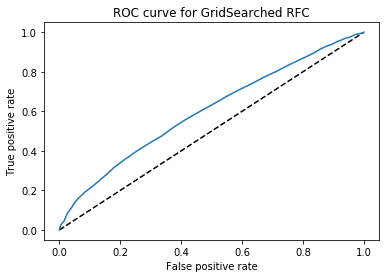



Report for: Adaboosted
             precision    recall  f1-score   support

        low       0.48      0.02      0.05      1981
       high       0.67      0.99      0.80      4018

avg / total       0.61      0.67      0.55      5999

Confusion Matrix
 [[  48 1933]
 [  53 3965]]
F1 Score: 0.799717628076
Accuracy: 0.668944824137
Log Loss: 11.4344983401
AUC Score: 0.595448322026


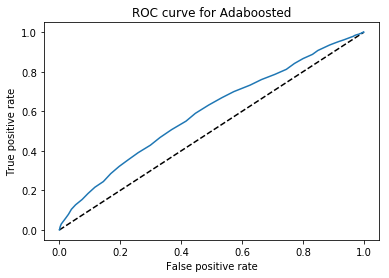



Report for: XG RS
             precision    recall  f1-score   support

        low       0.25      0.00      0.00      1981
       high       0.67      1.00      0.80      4018

avg / total       0.53      0.67      0.54      5999

Confusion Matrix
 [[   1 1980]
 [   3 4015]]
F1 Score: 0.801957455308
Accuracy: 0.669444907485
Log Loss: 11.4172323377
AUC Score: 0.62902382238


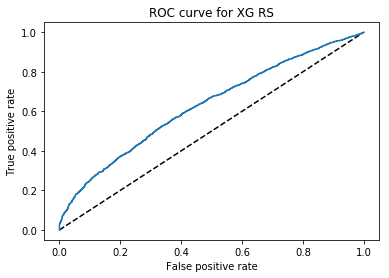



Report for: XG CS
             precision    recall  f1-score   support

        low       0.00      0.00      0.00      1981
       high       0.67      1.00      0.80      4018

avg / total       0.45      0.67      0.54      5999

Confusion Matrix
 [[   0 1981]
 [   1 4017]]
F1 Score: 0.802116613419
Accuracy: 0.669611601934
Log Loss: 11.4114750487
AUC Score: 0.628723997941


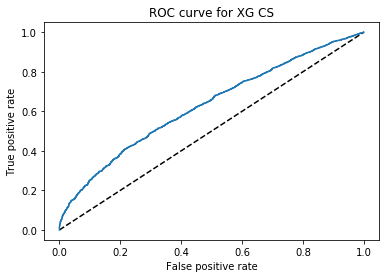



Report for: XG SS
             precision    recall  f1-score   support

        low       0.00      0.00      0.00      1981
       high       0.67      1.00      0.80      4018

avg / total       0.45      0.67      0.54      5999

Confusion Matrix
 [[   0 1981]
 [   0 4018]]
F1 Score: 0.802236198463
Accuracy: 0.669778296383
Log Loss: 11.4057176264
AUC Score: 0.636183049573


/home/munaf/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


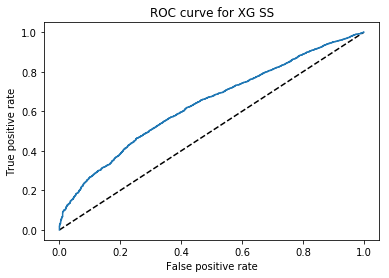


*****EOF: stats_posts_with_readibility_measures*****


In [22]:
#RunForrestRun(stats) #DONT RUN THIS BLOCK. WILL TAKE 1HOUR+ TO GENERATE RESULTS


Running for iot_posts_with_readibility_measures
dataset size is: (1048, 10)
columns: Index(['Flesch_Reading_Ease_Value', 'Coleman_Liau_Index_Value',
       'Dale_Chall_Readability_Score', 'Code_Count', 'Latex_Count',
       'Text_Length', 'Punc_Rate', 'Polarity', 'Subjectivity', 'ScoreLabel'],
      dtype='object')

Random Forest
Best parameters were {'criterion': 'entropy', 'n_estimators': 60, 'max_features': 'log2'} with an accuracy of: 0.7303102625298329 over the leftout tr set

Adaboosted
mean crossvalidated accuracy for training set after Adaboost: 0.707487091222031

XG Boosted
accuracy for best row sampling on leftout set: 0.856801909308
accuracy for best col sampling on leftout set: 0.846062052506
accuracy for best split sampling on leftout set: 0.800715990453
*****BOF: iot_posts_with_readibility_measures*****

Report for: GridSearched RFC
             precision    recall  f1-score   support

        low       0.67      0.24      0.35       101
       high       0.55      0.89 

/home/munaf/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


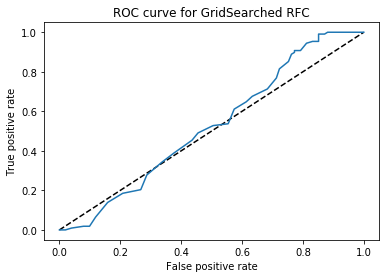



Report for: Adaboosted
             precision    recall  f1-score   support

        low       0.59      0.26      0.36       101
       high       0.55      0.83      0.66       108

avg / total       0.57      0.56      0.51       209

Confusion Matrix
 [[26 75]
 [18 90]]
F1 Score: 0.659340659341
Accuracy: 0.555023923445
Log Loss: 15.3692161461
AUC Score: 0.528832049872


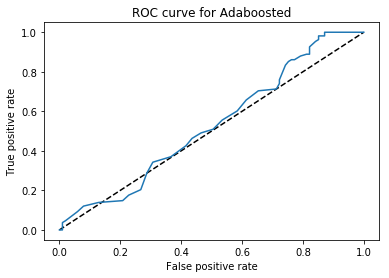



Report for: XG RS
             precision    recall  f1-score   support

        low       0.66      0.27      0.38       101
       high       0.56      0.87      0.68       108

avg / total       0.61      0.58      0.54       209

Confusion Matrix
 [[27 74]
 [14 94]]
F1 Score: 0.68115942029
Accuracy: 0.578947368421
Log Loss: 14.5429258036
AUC Score: 0.597818115145


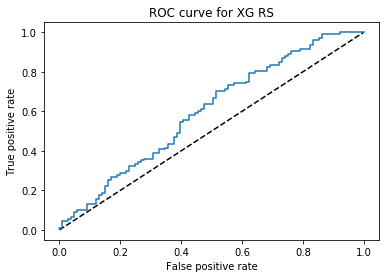



Report for: XG CS
             precision    recall  f1-score   support

        low       0.70      0.23      0.34       101
       high       0.56      0.91      0.69       108

avg / total       0.62      0.58      0.52       209

Confusion Matrix
 [[23 78]
 [10 98]]
F1 Score: 0.69014084507
Accuracy: 0.578947368421
Log Loss: 14.5429411069
AUC Score: 0.575357535754


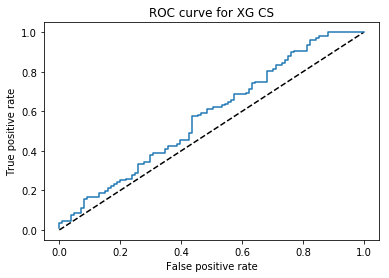



Report for: XG SS
             precision    recall  f1-score   support

        low       0.65      0.22      0.33       101
       high       0.55      0.89      0.68       108

avg / total       0.60      0.56      0.51       209

Confusion Matrix
 [[22 79]
 [12 96]]
F1 Score: 0.678445229682
Accuracy: 0.564593301435
Log Loss: 15.0387168427
AUC Score: 0.571323799047


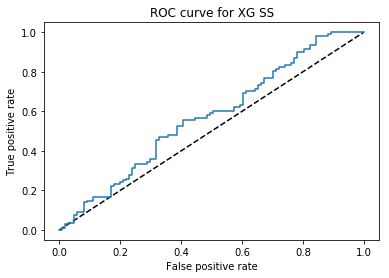


*****EOF: iot_posts_with_readibility_measures*****


In [25]:
RunForrestRun(iot)


Running for ai_posts_with_readibility_measures
dataset size is: (1680, 10)
columns: Index(['Flesch_Reading_Ease_Value', 'Coleman_Liau_Index_Value',
       'Dale_Chall_Readability_Score', 'Code_Count', 'Latex_Count',
       'Text_Length', 'Punc_Rate', 'Polarity', 'Subjectivity', 'ScoreLabel'],
      dtype='object')

Random Forest
Best parameters were {'criterion': 'gini', 'n_estimators': 50, 'max_features': 'log2'} with an accuracy of: 0.5639880952380952 over the leftout tr set

Adaboosted
mean crossvalidated accuracy for training set after Adaboost: 0.5446158098396905

XG Boosted
accuracy for best row sampling on leftout set: 0.747767857143
accuracy for best col sampling on leftout set: 0.75744047619
accuracy for best split sampling on leftout set: 0.744047619048
*****BOF: ai_posts_with_readibility_measures*****

Report for: GridSearched RFC
             precision    recall  f1-score   support

        low       0.72      0.74      0.73       228
       high       0.42      0.39      

/home/munaf/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


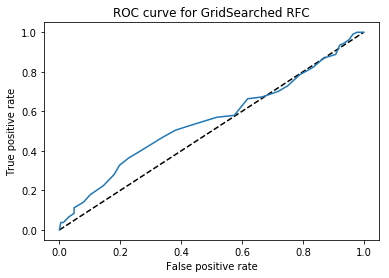



Report for: Adaboosted
             precision    recall  f1-score   support

        low       0.73      0.78      0.75       228
       high       0.45      0.38      0.41       107

avg / total       0.64      0.65      0.64       335

Confusion Matrix
 [[177  51]
 [ 66  41]]
F1 Score: 0.412060301508
Accuracy: 0.650746268657
Log Loss: 12.0629182617
AUC Score: 0.549577799639


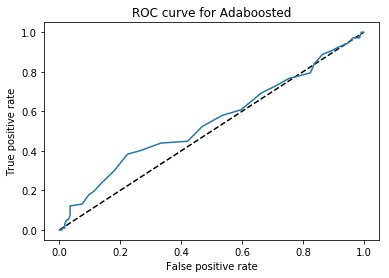



Report for: XG RS
             precision    recall  f1-score   support

        low       0.70      0.75      0.72       228
       high       0.37      0.32      0.34       107

avg / total       0.60      0.61      0.60       335

Confusion Matrix
 [[171  57]
 [ 73  34]]
F1 Score: 0.343434343434
Accuracy: 0.611940298507
Log Loss: 13.4032433086
AUC Score: 0.54455648467


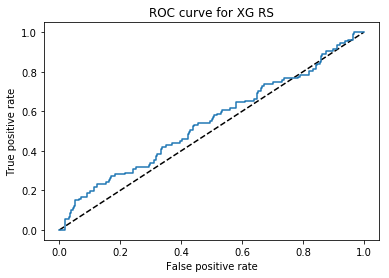



Report for: XG CS
             precision    recall  f1-score   support

        low       0.69      0.75      0.72       228
       high       0.35      0.28      0.31       107

avg / total       0.58      0.60      0.59       335

Confusion Matrix
 [[172  56]
 [ 77  30]]
F1 Score: 0.310880829016
Accuracy: 0.602985074627
Log Loss: 13.712543397
AUC Score: 0.545581242827


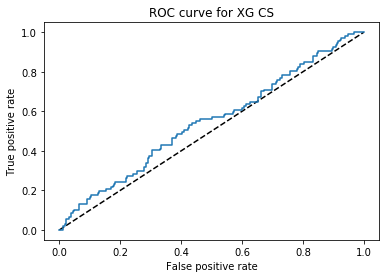



Report for: XG SS
             precision    recall  f1-score   support

        low       0.72      0.75      0.74       228
       high       0.42      0.37      0.39       107

avg / total       0.62      0.63      0.63       335

Confusion Matrix
 [[172  56]
 [ 67  40]]
F1 Score: 0.394088669951
Accuracy: 0.632835820896
Log Loss: 12.6815351464
AUC Score: 0.555746843745


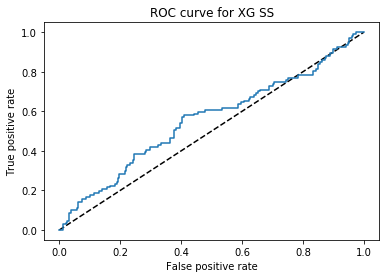


*****EOF: ai_posts_with_readibility_measures*****


In [26]:
RunForrestRun(ai)

In [29]:
# Score = 2
iot2 = 's2_iot_posts_with_readibility_measures'
ai2 = 's2_ai_posts_with_readibility_measures'
stats2 = 's2_stats_posts_with_readibility_measures'


Running for s2_stats_posts_with_readibility_measures
dataset size is: (30000, 10)
columns: Index(['Flesch_Reading_Ease_Value', 'Coleman_Liau_Index_Value',
       'Dale_Chall_Readability_Score', 'Code_Count', 'Latex_Count',
       'Text_Length', 'Punc_Rate', 'Polarity', 'Subjectivity', 'ScoreLabel'],
      dtype='object')

Random Forest
Best parameters were {'criterion': 'entropy', 'n_estimators': 90, 'max_features': 'log2'} with an accuracy of: 0.588625 over the leftout tr set

Adaboosted
mean crossvalidated accuracy for training set after Adaboost: 0.5818344467956216

XG Boosted
accuracy for best row sampling on leftout set: 0.625791666667
accuracy for best col sampling on leftout set: 0.625916666667
accuracy for best split sampling on leftout set: 0.625291666667
*****BOF: s2_stats_posts_with_readibility_measures*****

Report for: GridSearched RFC
             precision    recall  f1-score   support

        low       0.59      0.25      0.35      2935
       high       0.54      0.8

/home/munaf/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


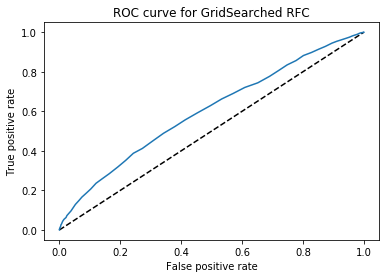



Report for: Adaboosted
             precision    recall  f1-score   support

        low       0.60      0.25      0.35      2935
       high       0.54      0.84      0.66      3064

avg / total       0.57      0.55      0.51      5999

Confusion Matrix
 [[ 721 2214]
 [ 480 2584]]
F1 Score: 0.657339099466
Accuracy: 0.550925154192
Log Loss: 15.5107907846
AUC Score: 0.594653635559


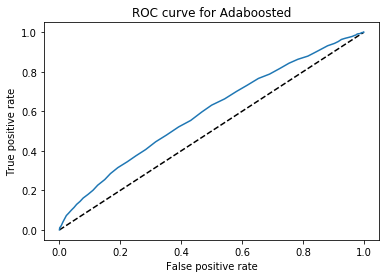



Report for: XG RS
             precision    recall  f1-score   support

        low       0.69      0.08      0.14      2935
       high       0.52      0.96      0.68      3064

avg / total       0.60      0.53      0.42      5999

Confusion Matrix
 [[ 237 2698]
 [ 108 2956]]
F1 Score: 0.678137187428
Accuracy: 0.532255375896
Log Loss: 16.1556865941
AUC Score: 0.624335304531


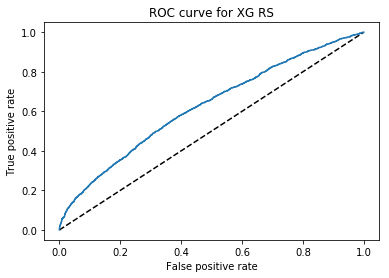



Report for: XG CS
             precision    recall  f1-score   support

        low       0.70      0.07      0.12      2935
       high       0.52      0.97      0.68      3064

avg / total       0.61      0.53      0.41      5999

Confusion Matrix
 [[ 201 2734]
 [  87 2977]]
F1 Score: 0.678518518519
Accuracy: 0.52975495916
Log Loss: 16.242052727
AUC Score: 0.625580962188


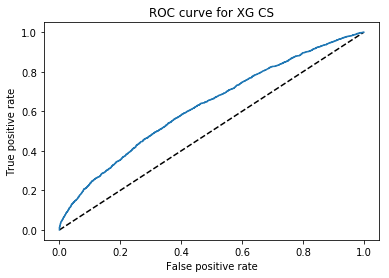



Report for: XG SS
             precision    recall  f1-score   support

        low       0.68      0.07      0.12      2935
       high       0.52      0.97      0.68      3064

avg / total       0.60      0.53      0.41      5999

Confusion Matrix
 [[ 199 2736]
 [  93 2971]]
F1 Score: 0.67745981074
Accuracy: 0.528421403567
Log Loss: 16.288112372
AUC Score: 0.625680430209


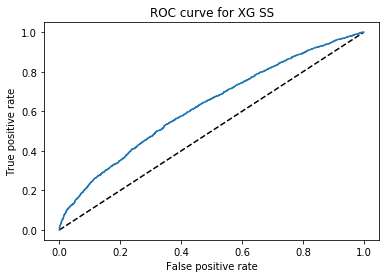


*****EOF: s2_stats_posts_with_readibility_measures*****


In [43]:
RunForrestRun(stats2)


Running for s2_iot_posts_with_readibility_measures
dataset size is: (1048, 10)
columns: Index(['Flesch_Reading_Ease_Value', 'Coleman_Liau_Index_Value',
       'Dale_Chall_Readability_Score', 'Code_Count', 'Latex_Count',
       'Text_Length', 'Punc_Rate', 'Polarity', 'Subjectivity', 'ScoreLabel'],
      dtype='object')

Random Forest
Best parameters were {'criterion': 'entropy', 'n_estimators': 60, 'max_features': 'sqrt'} with an accuracy of: 0.8615751789976134 over the leftout tr set

Adaboosted
mean crossvalidated accuracy for training set after Adaboost: 0.8567932233134217

XG Boosted
accuracy for best row sampling on leftout set: 0.908114558473
accuracy for best col sampling on leftout set: 0.918854415274
accuracy for best split sampling on leftout set: 0.917661097852
*****BOF: s2_iot_posts_with_readibility_measures*****

Report for: GridSearched RFC
             precision    recall  f1-score   support

        low       0.50      0.26      0.34        43
       high       0.83    

/home/munaf/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


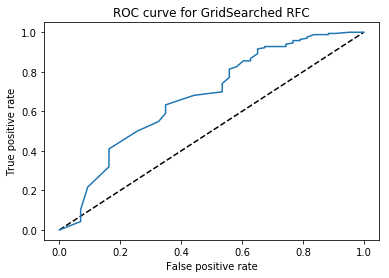



Report for: Adaboosted
             precision    recall  f1-score   support

        low       0.60      0.28      0.38        43
       high       0.84      0.95      0.89       166

avg / total       0.79      0.81      0.79       209

Confusion Matrix
 [[ 12  31]
 [  8 158]]
F1 Score: 0.89014084507
Accuracy: 0.813397129187
Log Loss: 6.44515343025
AUC Score: 0.642897170076


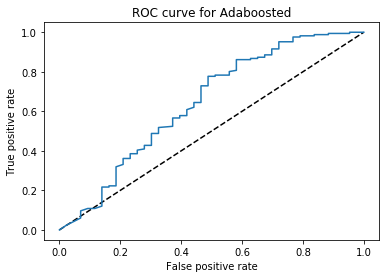



Report for: XG RS
             precision    recall  f1-score   support

        low       0.55      0.28      0.37        43
       high       0.83      0.94      0.88       166

avg / total       0.77      0.80      0.78       209

Confusion Matrix
 [[ 12  31]
 [ 10 156]]
F1 Score: 0.883852691218
Accuracy: 0.803827751196
Log Loss: 6.7756680369
AUC Score: 0.673858223592


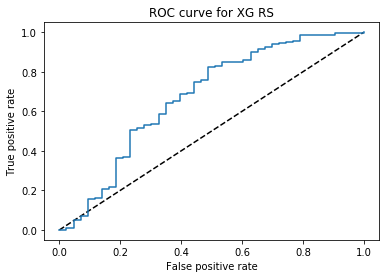



Report for: XG CS
             precision    recall  f1-score   support

        low       0.52      0.28      0.36        43
       high       0.83      0.93      0.88       166

avg / total       0.77      0.80      0.77       209

Confusion Matrix
 [[ 12  31]
 [ 11 155]]
F1 Score: 0.880681818182
Accuracy: 0.799043062201
Log Loss: 6.94092534022
AUC Score: 0.687027178481


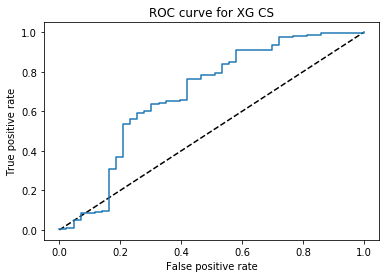



Report for: XG SS
             precision    recall  f1-score   support

        low       0.57      0.30      0.39        43
       high       0.84      0.94      0.89       166

avg / total       0.78      0.81      0.79       209

Confusion Matrix
 [[ 13  30]
 [ 10 156]]
F1 Score: 0.886363636364
Accuracy: 0.808612440191
Log Loss: 6.61040690775
AUC Score: 0.684785654245


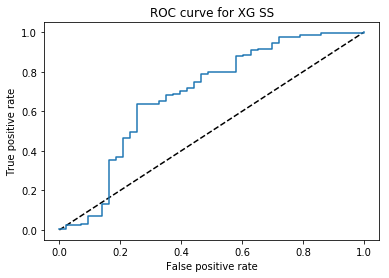


*****EOF: s2_iot_posts_with_readibility_measures*****


In [30]:
RunForrestRun(iot2)


Running for s2_ai_posts_with_readibility_measures
dataset size is: (1680, 10)
columns: Index(['Flesch_Reading_Ease_Value', 'Coleman_Liau_Index_Value',
       'Dale_Chall_Readability_Score', 'Code_Count', 'Latex_Count',
       'Text_Length', 'Punc_Rate', 'Polarity', 'Subjectivity', 'ScoreLabel'],
      dtype='object')

Random Forest
Best parameters were {'criterion': 'gini', 'n_estimators': 50, 'max_features': None} with an accuracy of: 0.5632440476190477 over the leftout tr set

Adaboosted
mean crossvalidated accuracy for training set after Adaboost: 0.5394472084024323

XG Boosted
accuracy for best row sampling on leftout set: 0.747767857143
accuracy for best col sampling on leftout set: 0.75744047619
accuracy for best split sampling on leftout set: 0.744047619048
*****BOF: s2_ai_posts_with_readibility_measures*****

Report for: GridSearched RFC
             precision    recall  f1-score   support

        low       0.73      0.70      0.71       228
       high       0.41      0.44  

/home/munaf/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


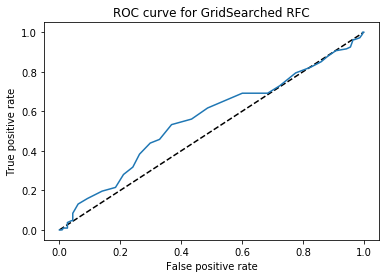



Report for: Adaboosted
             precision    recall  f1-score   support

        low       0.72      0.70      0.71       228
       high       0.40      0.43      0.42       107

avg / total       0.62      0.61      0.62       335

Confusion Matrix
 [[160  68]
 [ 61  46]]
F1 Score: 0.41628959276
Accuracy: 0.614925373134
Log Loss: 13.300168739
AUC Score: 0.571753566158


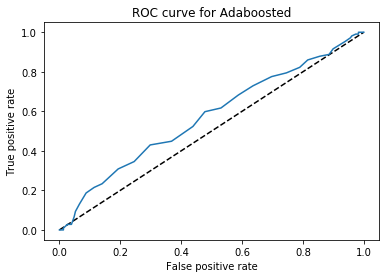



Report for: XG RS
             precision    recall  f1-score   support

        low       0.70      0.75      0.72       228
       high       0.37      0.32      0.34       107

avg / total       0.60      0.61      0.60       335

Confusion Matrix
 [[171  57]
 [ 73  34]]
F1 Score: 0.343434343434
Accuracy: 0.611940298507
Log Loss: 13.4032433086
AUC Score: 0.54455648467


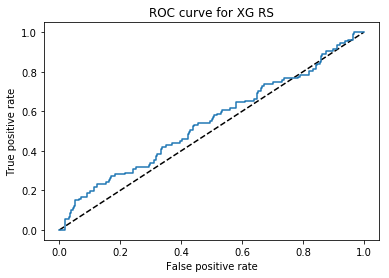



Report for: XG CS
             precision    recall  f1-score   support

        low       0.69      0.75      0.72       228
       high       0.35      0.28      0.31       107

avg / total       0.58      0.60      0.59       335

Confusion Matrix
 [[172  56]
 [ 77  30]]
F1 Score: 0.310880829016
Accuracy: 0.602985074627
Log Loss: 13.712543397
AUC Score: 0.545581242827


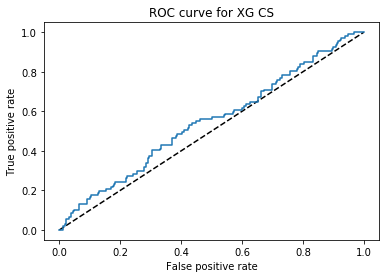



Report for: XG SS
             precision    recall  f1-score   support

        low       0.72      0.75      0.74       228
       high       0.42      0.37      0.39       107

avg / total       0.62      0.63      0.63       335

Confusion Matrix
 [[172  56]
 [ 67  40]]
F1 Score: 0.394088669951
Accuracy: 0.632835820896
Log Loss: 12.6815351464
AUC Score: 0.555746843745


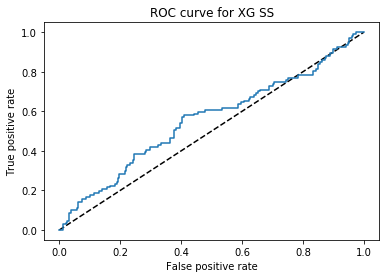


*****EOF: s2_ai_posts_with_readibility_measures*****


In [31]:
RunForrestRun(ai2)

In [40]:
## DO MORE STUFF
# TFIDF

def doTFIDFStuff(filename):
    from sklearn.feature_extraction.text import CountVectorizer
    import sklearn
    
    df = pd.read_csv(filename+'.csv', sep=",")

    # removing unnecessary columns. keeping only numbers atm
    unnecessary = ['Body','ClosedDate','CommunityOwnedDate','CreationDate','Id','LastActivityDate',
              'LastEditDate','LastEditorUserId','LastEditorDisplayName','OwnerDisplayName',
              'OwnerUserId','ParentId','Tags','Title','AcceptedAnswerId','Score',
              'AnswerCount', 'CommentCount', 'FavoriteCount', 'PostTypeId','ViewCount']

    droppable = np.intersect1d(df.columns,unnecessary)
    df = df.drop(droppable, 1)
    df = df.dropna()
    if df.shape[0]>30000:
        df = df[:30000]

    df = df[['Clean_Text','ScoreLabel']]
    # calculate the BOW representation
    vectorizer = CountVectorizer(min_df=1)
    word_counts = vectorizer.fit_transform((df['Clean_Text']))

    # TFIDF
    tf_transformer = sklearn.feature_extraction.text.TfidfTransformer(use_idf=True).fit(word_counts)
    X = tf_transformer.transform(word_counts)
    y = df['ScoreLabel']

    X_tr = X[:int(len(df)*0.8)]
    Y_tr = y.iloc[:int(len(df)*0.8)]
    
    X_te = X[int(len(df)*0.8)+1:]
    Y_te = y.iloc[int(len(df)*0.8)+1:]
    
    print("\nRandom Forest")
    best_rfc =  gridSearching(RandomForestClassifier(),X_tr,Y_tr)
    grid_rfc_pred = best_rfc.predict(X_te)
    grid_rfc_pred_prob = best_rfc.predict_proba(X_te)

    print("\nAdaboosted")
    adaboosted = adaboostedRFC(best_rfc,X_tr,Y_tr)
    ada_pred = adaboosted.predict(X_te)
    ada_pred_prob = adaboosted.predict_proba(X_te)
       
   
    print("*****BOF: {}*****".format(filename))
    reportCard(Y_te, grid_rfc_pred, grid_rfc_pred_prob,'GridSearched RFC')
    reportCard(Y_te, ada_pred, ada_pred_prob,'Adaboosted')
    print("*****EOF: {}*****".format(filename))


Random Forest
Best parameters were {'criterion': 'entropy', 'n_estimators': 60, 'max_features': 'sqrt'} with an accuracy of: 0.9260143198090692 over the leftout tr set

Adaboosted
mean crossvalidated accuracy for training set after Adaboost: 0.9209965914076473
*****BOF: s2_iot_posts_with_readibility_measures*****

Report for: GridSearched RFC
             precision    recall  f1-score   support

        low       1.00      0.26      0.41        43
       high       0.84      1.00      0.91       166

avg / total       0.87      0.85      0.81       209

Confusion Matrix
 [[ 11  32]
 [  0 166]]
F1 Score: 0.912087912088
Accuracy: 0.846889952153
Log Loss: 5.2883561328
AUC Score: 0.62076211824


/home/munaf/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


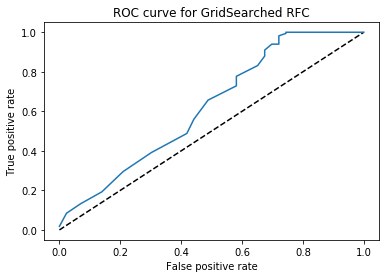



Report for: Adaboosted
             precision    recall  f1-score   support

        low       1.00      0.23      0.38        43
       high       0.83      1.00      0.91       166

avg / total       0.87      0.84      0.80       209

Confusion Matrix
 [[ 10  33]
 [  0 166]]
F1 Score: 0.909589041096
Accuracy: 0.842105263158
Log Loss: 5.45361726195
AUC Score: 0.637013168955


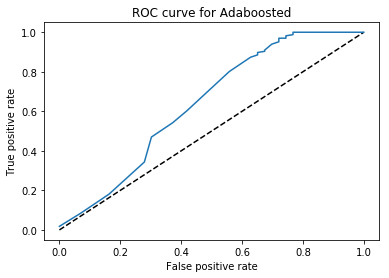


*****EOF: s2_iot_posts_with_readibility_measures*****


In [41]:
doTFIDFStuff(iot2)


Random Forest
Best parameters were {'criterion': 'gini', 'n_estimators': 80, 'max_features': None} with an accuracy of: 0.5870535714285714 over the leftout tr set

Adaboosted
mean crossvalidated accuracy for training set after Adaboost: 0.5558153676064124
*****BOF: s2_ai_posts_with_readibility_measures*****

Report for: GridSearched RFC
             precision    recall  f1-score   support

        low       0.71      0.81      0.76       228
       high       0.42      0.29      0.34       107

avg / total       0.62      0.64      0.62       335

Confusion Matrix
 [[185  43]
 [ 76  31]]
F1 Score: 0.342541436464
Accuracy: 0.644776119403
Log Loss: 12.269100817
AUC Score: 0.604238399738


/home/munaf/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


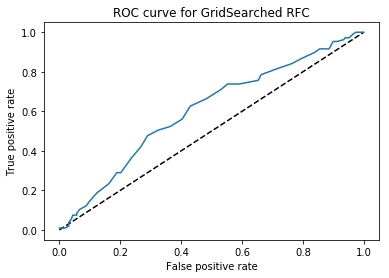



Report for: Adaboosted
             precision    recall  f1-score   support

        low       0.68      0.78      0.73       228
       high       0.33      0.23      0.27       107

avg / total       0.57      0.61      0.58       335

Confusion Matrix
 [[178  50]
 [ 82  25]]
F1 Score: 0.274725274725
Accuracy: 0.605970149254
Log Loss: 13.6094282507
AUC Score: 0.560850139367


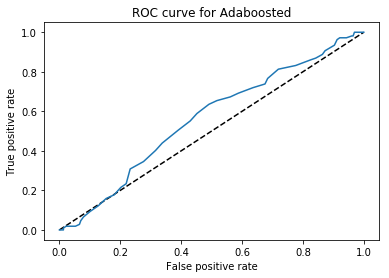


*****EOF: s2_ai_posts_with_readibility_measures*****


In [42]:
doTFIDFStuff(ai2)